In [31]:
#figure out why u=0 does not give rho0 for r=2.3
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm.auto import trange,tqdm
from time import time
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
from numpy import sqrt
import scipy
from itertools import repeat
from numba import njit

import DEDlib

In [34]:
filenames=tqdm(['cssnt0_25','cssnt0_5','cssnt1','cssnt1_5','cssnt2'],position=2,leave=False,desc='No. t variation sims',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
len(filenames)        

No. t variation sims:   0%|          | 0/5 [00:00<?, ?it/s]

5

In [25]:
input=np.array([[{"U":1,"Sigma":0.5,"Ed":-0.5,"U2":1,"J":0},{"U":2,"Sigma":1,"Ed":-1,"U2":2,"J":0},{"U":3,"Sigma":1.5,"Ed":-1.5,"U2":3,"J":0},{"U":4,"Sigma":2,"Ed":-2,"U2":4,"J":0}],
       [{"U":1.5,"Sigma":2.25,"Ed":-2.25,"U2":1.5,"J":0},{"U":3,"Sigma":4.5,"Ed":-4.5,"U2":3,"J":0},{"U":4.5,"Sigma":6.75,"Ed":-6.75,"U2":4.5,"J":0},{"U":6,"Sigma":9,"Ed":-9,"U2":6,"J":0}],
       [{"U":3.5,"Sigma":4.625,"Ed":-4.625,"U2":3,"J":0.25},{"U":3.5,"Sigma":4,"Ed":-4,"U2":2.5,"J":0.5},{"U":3.5,"Sigma":3.375,"Ed":-3.375,"U2":2,"J":0.75},{"U":3.5,"Sigma":2.75,"Ed":-2.75,"U2":1.5,"J":1}],])

input.shape 

(3, 4)

In [29]:
str(tes['Sigma']),str(3+3)

('0.5', '6')

In [16]:
tes={"U":1,"Sigma":0.5,"Ed":-0.5,"U2":1}

tes["J"]

KeyError: 'J'

In [ ]:
    input={"N" : 4000, "poles" : 2, "Ed" : -3/2, "ctype" : 'n'}
    file,labelnames='constraintN2p','$\\rho_{constr.},N,$n=2'
    nd, _, fDOS, Lor, omega, selectpT, selectpcT,tsim=DEDlib.main(**input)
    DEDlib.DOSplot(fDOS, Lor, omega,file,labelnames)

In [122]:
def main(N=200000,poles=4,U=3,Sigma=3/2,Ed=-3/2,Gamma=0.3,SizeO=1001,etaco=[0.02,1e-39],ctype='n',Edcalc='',bound=3,Tk=[0],Nimpurities=1,U2=0,J=0,posb=1):
    """main(N=1000000,poles=4,U=3,Sigma=3/2,Gamma=0.3,SizeO=1001,etaco=[0.02,1e-39], ctype='n',Ed='AS'). 
The main DED function simulating the Anderson impurity model for given parameters."""
    omega,eta,selectpcT,selectpT,Npoles=np.linspace(-bound,bound,SizeO),etaco[0]*abs(np.linspace(-bound,bound,SizeO))+etaco[1],[],[],int(poles/Nimpurities)
    c,pbar=[Jordan_wigner_transform(i,2*poles) for i in range(2*poles)],trange(N,position=posb,leave=False,desc='Iterations',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    (Hn,n),AvgSigmadat,Nfin,nd=Operators(c,Nimpurities,poles),np.zeros((len(Tk),SizeO),dtype='complex_'),np.zeros(len(Tk),dtype='float'),np.zeros(len(Tk),dtype='complex_')
    while pbar.n<N:
        reset=False
        while not reset:
            NewM,nonG,select=Startrans(Npoles,np.sort(Lorentzian(omega,Gamma,Npoles,Ed,Sigma)[1]),omega,eta)
            print(nonG.shape)
            H0,H=HamiltonianAIM(np.repeat(NewM[0][0],Nimpurities),np.tile([NewM[k+1][k+1] for k in range(len(NewM)-1)],(Nimpurities,1)),np.tile(NewM[0,1:],(Nimpurities,1)),U,Sigma,U2,J,Hn)
            try: (MBGdat,Boltzmann,Ev0),reset=Constraint(ctype,H0,H,omega,eta,c,n,Tk,np.array([ar<N for ar in Nfin]))
            except (np.linalg.LinAlgError,ValueError,scipy.sparse.linalg.ArpackNoConvergence): (MBGdat,Boltzmann,Ev0),reset=(np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
            if np.isnan(1/nonG-1/MBGdat+Sigma).any() or np.array([i>=1000 for i in np.real(1/nonG-1/MBGdat+Sigma)]).any(): reset=False
            selectpT.append(select)
        Nfin,AvgSigmadat,nd=Nfin+Boltzmann,AvgSigmadat+(1/nonG-1/MBGdat+Sigma)*Boltzmann[:,None],nd+np.conj(Ev0).T@(c[0].dag()*c[0]+c[1].dag()*c[1]).data.tocoo()@Ev0*Boltzmann
        selectpcT.append(select)
        if ctype=='sn': pbar.n+=1
        else: pbar.n=int(min(Nfin))
        pbar.refresh()
    pbar.close()
    if Edcalc == 'AS': return (Nfin.squeeze(),np.real(nd/Nfin).squeeze()),(AvgSigmadat/Nfin[:,None]).squeeze(),(-np.imag(np.nan_to_num(1/(omega-AvgSigmadat/Nfin[:,None]+(AvgSigmadat[:,int(np.round(SizeO/2))]/Nfin)[:,None]+1j*Gamma)))/np.pi).squeeze(),Lorentzian(omega,Gamma,poles)[0],omega,selectpT,selectpcT,pbar.format_dict["elapsed"]
    else: return (Nfin.squeeze(),np.real(nd/Nfin).squeeze()),(AvgSigmadat/Nfin[:,None]).squeeze(),(-np.imag(np.nan_to_num(1/(omega-AvgSigmadat/Nfin[:,None]-Ed+1j*Gamma)))/np.pi).squeeze(),Lorentzian(omega,Gamma,poles,Ed,Sigma)[0],omega,selectpT,selectpcT,pbar.format_dict["elapsed"]


In [71]:
input={"N" : 1, "poles" : 2, "Ed" : -3/2, "ctype" : 'n'}
file,labelnames='constraintN2p','$\\rho_{constr.},N,$n=2'
nd, _, fDOS, Lor, omega, selectpT, selectpcT,tsim=main(**input)

Iterations:   0%|          | 0/1 [00:00<?, ?it/s]

(1001,)


In [73]:
input={"N" : 1, "poles" : 2, "Ed" : -3/2, "ctype" : 'n'}
file,labelnames='constraintN2p','$\\rho_{constr.},N,$n=2'
nd, _, fDOS, Lor, omega, selectpT, selectpcT,tsim=main(**input)

Iterations:   0%|          | 0/1 [00:00<?, ?it/s]

(1001,)
(1001,)


In [116]:
N=1
poles=4
U=3
Sigma=3/2
Ed=-3/2
Gamma=0.3
SizeO=1001
etaco=[0.02,1e-39]
ctype='n'
Edcalc=''
bound=3
Tk=[0]
Nimpurities=1
U2=0
J=0
posb=1
omega,eta,selectpcT,selectpT,Npoles=np.linspace(-bound,bound,SizeO),etaco[0]*abs(np.linspace(-bound,bound,SizeO))+etaco[1],[],[],int(poles/Nimpurities)
c,pbar=[Jordan_wigner_transform(i,2*poles) for i in range(2*poles)],trange(N,position=posb,leave=False,desc='Iterations',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
(Hn,n),Nfin,nd=Operators(c,Nimpurities,poles),np.zeros(len(Tk),dtype='float'),np.zeros(len(Tk),dtype='complex_')

AvgSigmadat2=np.zeros((len(Tk),SizeO),dtype='complex_')
AvgSigmadat=np.zeros((len(Tk),SizeO),dtype='complex_')

reset,NewMm,nonGm,selectm=False,np.zeros((Nimpurities,Npoles,Npoles)),np.zeros((Nimpurities,SizeO),dtype='complex_'),np.zeros((Nimpurities,Npoles))
NewM,nonG,select=Startrans(Npoles,np.sort(Lorentzian(omega,Gamma,Npoles,Ed,Sigma)[1]),omega,eta)


NewM,nonGm[0],selectm=NewM,nonG,select
for i in range(Nimpurities): NewMm[i]=NewM

H0,H=HamiltonianAIM(np.repeat(NewM[0][0],Nimpurities),np.tile([NewM[k+1][k+1] for k in range(len(NewM)-1)],(Nimpurities,1)),np.tile(NewM[0,1:],(Nimpurities,1)),U,Sigma,U2,J,Hn)
            
H02,H2=HamiltonianAIM(NewMm[:,0,0],[[NewMm[l,k+1,k+1] for k in range(Npoles-1)] for l in range(Nimpurities)],NewMm[:,0,1:],U,Sigma,U2,J,Hn)
try: (MBGdat,Boltzmann,Ev0),reset=Constraint(ctype,H0,H,omega,eta,c,n,Tk,np.array([ar<N for ar in Nfin]))
except (np.linalg.LinAlgError,ValueError,scipy.sparse.linalg.ArpackNoConvergence): (MBGdat,Boltzmann,Ev0),reset=(np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
if np.isnan(1/nonG-1/MBGdat+Sigma).any() or np.array([i>=1000 for i in np.real(1/nonG-1/MBGdat+Sigma)]).any(): reset=False

AvgSigmadat=AvgSigmadat+(1/nonG-1/MBGdat+Sigma)*Boltzmann[:,None]


AvgSigmadat2=AvgSigmadat2+(1/nonGm[0]-1/MBGdat+Sigma)*Boltzmann[:,None]
        

Iterations:   0%|          | 0/1 [00:00<?, ?it/s]

In [118]:
AvgSigmadat2==AvgSigmadat

array([[ True,  True,  True, ...,  True,  True,  True]])

In [121]:
AvgSigmadat,AvgSigmadat2

(array([[0.66508179-0.02216835j, 0.66286259-0.02228857j,
         0.66062697-0.02241087j, ..., 2.52153968-0.06802608j,
         2.51831431-0.06647109j, 2.51488186-0.06486508j]]),
 array([[0.66508179-0.02216835j, 0.66286259-0.02228857j,
         0.66062697-0.02241087j, ..., 2.52153968-0.06802608j,
         2.51831431-0.06647109j, 2.51488186-0.06486508j]]))

In [127]:
def Jordan_wigner_transform(j,lattice_length):
    """Jordan_wigner_transform(j, lattice_length). 
Defines the Jordan Wigner transformation for a 1D lattice."""
    operators=sigmaz()
    for _ in range(j-1): operators=tensor(operators,sigmaz())
    if j == 0: operators=sigmam()
    else: operators=tensor(operators,sigmam())
    for _ in range(lattice_length - j - 1): operators=tensor(operators,identity(2))
    return operators

@njit
def Lorentzian(omega,Gamma,poles,Ed=-3/2,Sigma=3/2):
    """Lorentzian(omega, Gamma, poles,Ed=-3/2,Sigma=3/2). 
Defines the non-interacting DOS (rho0) and selects random sites based on the number of sites in the 1D lattice model and the calculated distribution."""
    return -np.imag(1/(omega-Ed-Sigma+1j*Gamma))/np.pi,np.array([Gamma*np.tan(np.pi*(pi-1/2))+Ed+Sigma for pi in np.random.uniform(0,1,poles)])

@njit
def Startrans(poles,select,omega,eta,row=0):
    """Startrans(poles,select,row,omega, eta). 
Function to transform 1D lattice matrices in order to calculates parameters impengergy, bathenergy and Vkk from random sampling distribution."""
    Pbath,Dbath,pbar,G=np.zeros((poles,poles)),np.zeros((poles,poles)),np.zeros((poles,poles)),np.zeros(omega.shape,dtype='complex_')
    for i in range(poles-1):
        for j in range(poles-1):
            if j>=i: Pbath[i+1][j+1]=-1/np.sqrt((poles-i-1)*(poles-i))
        Pbath[i+1][i]=np.sqrt(poles-i-1)/np.sqrt(poles-i)
    Pbath[row,:]=1/np.sqrt(poles)
    for i, _ in enumerate(select): Dbath[i][i]=select[i]
    pbar[1:,1:]=np.linalg.eig((Pbath@Dbath@Pbath.T)[1:,1:])[1]
    pbar[row][row]=1
    for i, _ in enumerate(select): G+=1/len(select)/(omega-select[i]+1.j*eta)
    return pbar.T@Pbath@Dbath@Pbath.T@pbar,G,select

def Operators(c,Nimpurities,poles):
    posimp=[int(2*poles/Nimpurities*i) for i in range(Nimpurities)]
    impn=[sum([c[posimp[k]+i].dag()*c[posimp[k]+i] for i in range(2)]) for k in range(Nimpurities)]
    bathn=[[sum([c[2*j+i+2+posimp[k]].dag()*c[2*j+i+2+posimp[k]] for i in range(2)]) for j in range(int(poles/Nimpurities)-1)] for k in range(Nimpurities)]
    crossn=[[sum([c[posimp[k]+i].dag()*c[2*j+i+2+posimp[k]]+c[2*j+i+2+posimp[k]].dag()*c[posimp[k]+i] for i in range(2)]) for j in range(int(poles/Nimpurities)-1)] for k in range(Nimpurities)]
    Un=sum([c[posimp[k]].dag()*c[posimp[k]]*c[posimp[k]+1].dag()*c[posimp[k]+1] for k in range(Nimpurities)])
    Sigman=sum([c[posimp[k]].dag()*c[posimp[k]]+c[posimp[k]+1].dag()*c[posimp[k]+1] for k in range(Nimpurities)])
    U2n=sum([c[posimp[k]+i].dag()*c[posimp[k]+i]*c[posimp[l]+j].dag()*c[posimp[l]+j] for i in range(2) for j in range(2) for l in range(Nimpurities) for k in range(Nimpurities) if k !=l])
    Jn=sum([1/2*(c[posimp[k]].dag()*c[posimp[k]+1]*c[posimp[l]+1].dag()*c[posimp[l]]+c[posimp[k]+1].dag()*c[posimp[k]]*c[posimp[l]].dag()*c[posimp[l]+1])
                    +1/4*(c[posimp[k]].dag()*c[posimp[k]]-c[posimp[k]+1].dag()*c[posimp[k]+1])*(c[posimp[l]].dag()*c[posimp[l]]-c[posimp[l]+1].dag()*c[posimp[l]+1]) for l in range(Nimpurities) for k in range(Nimpurities) if k!=l])
    n=[sum([c[j+posimp[i]].dag()*c[j+posimp[i]] for j in range(2*int(poles/Nimpurities))]) for i in range(Nimpurities)]
    return (impn,bathn,crossn,Un,Sigman,U2n,Jn),n

def HamiltonianAIM(impenergy,bathenergy,Vkk,U,Sigma,U2,J,Hn,H0=0):
    """HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma). 
Based on energy parameters calculates the Hamiltonian of a single-impurity system."""
    for k in range(len(impenergy)):
        H0+=impenergy[k]*Hn[0][k]
        for j in range(len(bathenergy[k])): H0+=bathenergy[k][j]*Hn[1][k][j]+Vkk[k][j]*Hn[2][k][j]
    return H0,H0+U*Hn[3]-Sigma*Hn[4]+(U2/2-J/4)*Hn[5]-J*Hn[6]

@njit
def MBGT0(omega,eta,evals,exp,exp2):
    G=np.zeros(len(omega),dtype='complex_')
    for i,expi in enumerate(exp): G+=abs(expi)**2/(omega+evals[i+1]-evals[0]+1.j*eta)+abs(exp2[i])**2/(omega+evals[0]-evals[i+1]+1.j*eta)
    return G

@njit
def MBGTnonzero(omega,eta,evals,exp,exp2,eevals):
    G=np.zeros(len(omega),dtype='complex_')
    for i,evi in enumerate(evals):
        for j,evj in enumerate(evals):
            G+=(exp[i][j]*exp2[j][i]/(omega+evi-evj+1.j*eta)+exp[j][i]*exp2[i][j]/(omega+evj-evi+1.j*eta))*eevals[i]
    return G

def MBGAIM(omega,H,c,eta,Tk,Boltzmann,evals=[],evecs=[],etaoffset=1e-4,posoffset=np.zeros(1,dtype='int')):
    """MBGAIM(omega, H, c, eta). 
Calculates the many body Green's function based on the Hamiltonian eigenenergies/-states."""
    if ~np.any(evals): evals,evecs=scipy.linalg.eigh(H.data.toarray())
    if Tk==[0]:
        vecn=np.conj(evecs[:,1:]).T
        exp,exp2=vecn@c[0].data.tocoo()@evecs[:,0],vecn@c[0].dag().data.tocoo()@evecs[:,0]
        return MBGT0(omega,eta,evals,exp,exp2),Boltzmann,evecs[:,0]
    else:
        MGdat,eta[int(np.round(len(eta)/2))+posoffset]=np.ones((len(Tk),len(omega)),dtype='complex_'),etaoffset
        for k,T in enumerate(Tk):
            if Boltzmann[k]!=0:
                eevals=np.exp(-evals/T-scipy.special.logsumexp(-evals/T))
                vecn=np.conj(evecs).T
                exp,exp2=vecn@c[0].data.tocoo()@evecs,vecn@c[0].dag().data.tocoo()@evecs
                MGdat[k,:]=MBGTnonzero(omega,eta,evals,exp,exp2,eevals)
        return MGdat.squeeze(),Boltzmann,evecs[:,0]

def Constraint(ctype,H0,H,omega,eta,c,n,Tk,Nfin):
    """Constraint(ctype,H0,H,omega,eta,c,n). 
Constraint implementation function for DED method with various possible constraints."""
    if ctype[0]=='m':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.sparse.linalg.eigsh(np.real(H0.data),k=1,which='SA')[1][:,0],
                                        scipy.sparse.linalg.eigsh(np.real(H.data),k=1,which='SA')[1][:,0])))
        exp=np.conj(vecs)@n[0].data@vecs.T
        if ctype=='mosn' and np.round(exp[0,0])==np.round(exp[1,1]):
            return MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
        else:
            return (np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
    elif ctype[0]=='s':
        vecs=scipy.linalg.eigh(H0.data.toarray(),eigvals=[0,0])[1][:,0]
        evals,evecs=scipy.linalg.eigh(H.data.toarray())
        if ctype=='ssn':
            Boltzmann=np.exp(-abs(evals[find_nearest(np.diag(np.conj(evecs).T@n[0].data@evecs),np.conj(vecs)@n[0].data@vecs.T)]-evals[0])/Tk)*Nfin.astype('int')
            return MBGAIM(omega,H,c,eta,Tk,Boltzmann,evals,evecs,1e-4,np.array([-2,-1,0,1,2])),True
        else:
            return MBGAIM(omega,H,c,eta,Tk,np.exp(-abs(evals[find_nearest(np.diag(np.conj(evecs).T@n[0].data@evecs),np.conj(vecs)@n[0].data@vecs.T)]-evals[0])/Tk),evals,evecs,1e-4,np.array([-2,-1,0,1,2])),True
    elif ctype[0]=='n':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.sparse.linalg.eigsh(np.real(H0.data),k=1,which='SA')[1][:,0],
                                                scipy.sparse.linalg.eigsh(np.real(H.data),k=1,which='SA')[1][:,0])))
        exp=[np.conj(vecs)@ni.data@vecs.T for ni in n]
        if ctype=='n%2' and all([int(np.round(expi[0,0]))%2==int(np.round(expi[1,1]))%2 for expi in exp]):
            return MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
        elif ctype=='n' and all([np.round(expi[0,0])==np.round(expi[1,1]) for expi in exp]):
            return MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
        else:
            return (np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
    elif ctype[0]=='d':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.linalg.eigh(H.data.toarray(),eigvals=[0,0])[1][:,0],
                                                scipy.linalg.eigh(H0.data.toarray(),eigvals=[0,0])[1][:,0])))
        exp=[np.conj(vecs)@ni.data@vecs.T for ni in n]
        if ctype=='dn' and all([np.round(expi[0,0])==np.round(expi[1,1]) for expi in exp]):
            return MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
        else:
            return (np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
    else:
        return MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True

def main(N=200000,poles=4,U=3,Sigma=3/2,Ed=-3/2,Gamma=0.3,SizeO=1001,etaco=[0.02,1e-39],ctype='n',Edcalc='',bound=3,Tk=[0],Nimpurities=1,U2=0,J=0,posb=1):
    """main(N=1000000,poles=4,U=3,Sigma=3/2,Gamma=0.3,SizeO=1001,etaco=[0.02,1e-39], ctype='n',Ed='AS'). 
The main DED function simulating the Anderson impurity model for given parameters."""
    omega,eta,selectpcT,selectpT,Npoles=np.linspace(-bound,bound,SizeO),etaco[0]*abs(np.linspace(-bound,bound,SizeO))+etaco[1],[],[],int(poles/Nimpurities)
    c,pbar=[Jordan_wigner_transform(i,2*poles) for i in range(2*poles)],trange(N,position=posb,leave=False,desc='Iterations',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    (Hn,n),AvgSigmadat,Nfin,nd=Operators(c,Nimpurities,poles),np.zeros((len(Tk),SizeO),dtype='complex_'),np.zeros(len(Tk),dtype='float'),np.zeros(len(Tk),dtype='complex_')
    while pbar.n<N:
        reset,NewMm,nonGm,selectm=False,np.zeros((Nimpurities,Npoles,Npoles)),np.zeros((Nimpurities,SizeO),dtype='complex_'),np.zeros((Nimpurities,Npoles))
        while not reset:
            if ctype=='mosn':
                for i in range(Nimpurities): NewMm[i],nonGm[i],selectm[i]=Startrans(Npoles,np.sort(Lorentzian(omega,Gamma,Npoles,Ed,Sigma)[1]),omega,eta)
            else: 
                NewM,nonGm[0],selectm=Startrans(Npoles,np.sort(Lorentzian(omega,Gamma,Npoles,Ed,Sigma)[1]),omega,eta)
                for i in range(Nimpurities): NewMm[i]=NewM
            H0,H=HamiltonianAIM(NewMm[:,0,0],[[NewMm[l,k+1,k+1] for k in range(Npoles-1)] for l in range(Nimpurities)],NewMm[:,0,1:],U,Sigma,U2,J,Hn)
            try: (MBGdat,Boltzmann,Ev0),reset=Constraint(ctype,H0,H,omega,eta,c,n,Tk,np.array([ar<N for ar in Nfin]))
            except (np.linalg.LinAlgError,ValueError,scipy.sparse.linalg.ArpackNoConvergence): (MBGdat,Boltzmann,Ev0),reset=(np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
            if np.isnan(1/nonGm[0]-1/MBGdat+Sigma).any() or np.array([i>=1000 for i in np.real(1/nonGm[0]-1/MBGdat+Sigma)]).any(): reset=False
            selectpT.append(selectm)
        Nfin,AvgSigmadat,nd=Nfin+Boltzmann,AvgSigmadat+(1/nonGm[0]-1/MBGdat+Sigma)*Boltzmann[:,None],nd+np.conj(Ev0).T@(c[0].dag()*c[0]+c[1].dag()*c[1]).data.tocoo()@Ev0*Boltzmann
        selectpcT.append(selectm)
        if ctype=='sn': pbar.n+=1
        else: pbar.n=int(min(Nfin))
        pbar.refresh()
    pbar.close()
    if Edcalc == 'AS': return (Nfin.squeeze(),np.real(nd/Nfin).squeeze()),(AvgSigmadat/Nfin[:,None]).squeeze(),(-np.imag(np.nan_to_num(1/(omega-AvgSigmadat/Nfin[:,None]+(AvgSigmadat[:,int(np.round(SizeO/2))]/Nfin)[:,None]+1j*Gamma)))/np.pi).squeeze(),Lorentzian(omega,Gamma,poles)[0],omega,selectpT,selectpcT,pbar.format_dict["elapsed"]
    else: return (Nfin.squeeze(),np.real(nd/Nfin).squeeze()),(AvgSigmadat/Nfin[:,None]).squeeze(),(-np.imag(np.nan_to_num(1/(omega-AvgSigmadat/Nfin[:,None]-Ed+1j*Gamma)))/np.pi).squeeze(),Lorentzian(omega,Gamma,poles,Ed,Sigma)[0],omega,selectpT,selectpcT,pbar.format_dict["elapsed"]


Iterations:   0%|          | 0/4000 [00:00<?, ?it/s]

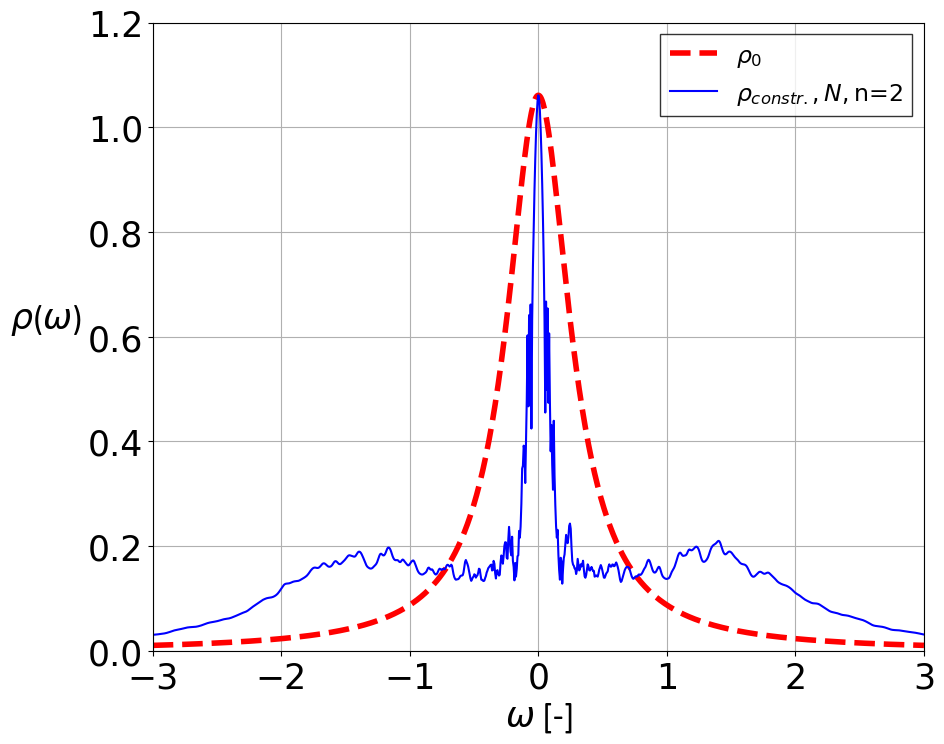

<module 'matplotlib.pyplot' from 'c:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\.conda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [128]:
input={"N" : 4000, "poles" : 2,"Sigma":3/2, "Ed" : -3/2, "U":3,"ctype" : 'n'}
file,labelnames='constraintN2p','$\\rho_{constr.},N,$n=2'
nd, _, fDOS, Lor, omega, selectpT, selectpcT,tsim=main(**input)
DEDlib.DOSplot(fDOS, Lor, omega,file,labelnames)

Iterations:   0%|          | 0/4000 [00:00<?, ?it/s]

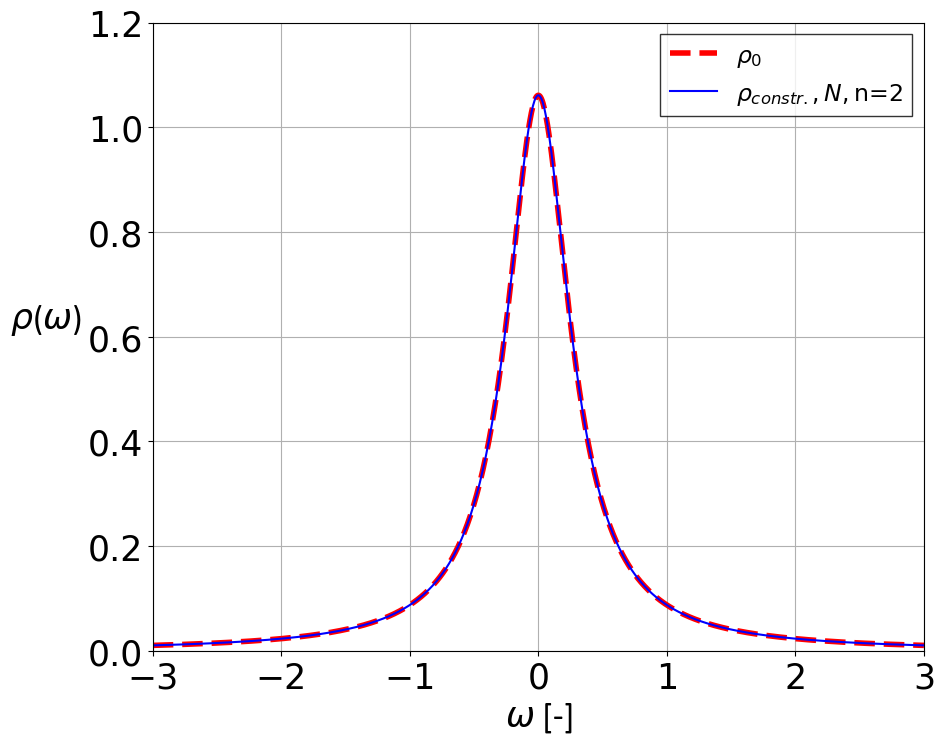

<module 'matplotlib.pyplot' from 'c:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\.conda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [59]:
input={"N" : 4000, "poles" : 2,"Sigma":0, "Ed" : 0, "U":0,"ctype" : 'n'}
file,labelnames='constraintN2p','$\\rho_{constr.},N,$n=2'
nd, _, fDOS, Lor, omega, selectpT, selectpcT,tsim=main(**input)
DEDlib.DOSplot(fDOS, Lor, omega,file,labelnames)

In [ ]:
def main(N=200000,poles=4,U=3,Sigma=3/2,Ed=-3/2,Gamma=0.3,SizeO=1001,etaco=[0.02,1e-39],ctype='n',Edcalc='',bound=3,Tk=[0],Nimpurities=1,U2=0,J=0,posb=1):
    """main(N=1000000,poles=4,U=3,Sigma=3/2,Gamma=0.3,SizeO=1001,etaco=[0.02,1e-39], ctype='n',Ed='AS'). 
The main DED function simulating the Anderson impurity model for given parameters."""
    omega,eta,selectpcT,selectpT,Npoles=np.linspace(-bound,bound,SizeO),etaco[0]*abs(np.linspace(-bound,bound,SizeO))+etaco[1],[],[],int(poles/Nimpurities)
    c,pbar=[Jordan_wigner_transform(i,2*poles) for i in range(2*poles)],trange(N,position=posb,leave=False,desc='Iterations',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    (Hn,n),AvgSigmadat,Nfin,nd=Operators(c,Nimpurities,poles),np.zeros((len(Tk),SizeO),dtype='complex_'),np.zeros(len(Tk),dtype='float'),np.zeros(len(Tk),dtype='complex_')
    while pbar.n<N:
        reset=False
        while not reset:
            NewM,nonG,select=Startrans(Npoles,np.sort(Lorentzian(omega,Gamma,Npoles,Ed,Sigma)[1]),omega,eta)
            H0,H=HamiltonianAIM(np.repeat(NewM[0][0],Nimpurities),np.tile([NewM[k+1][k+1] for k in range(len(NewM)-1)],(Nimpurities,1)),np.tile(NewM[0,1:],(Nimpurities,1)),U,Sigma,U2,J,Hn)
            try: (MBGdat,Boltzmann,Ev0),reset=Constraint(ctype,H0,H,omega,eta,c,n,Tk,np.array([ar<N for ar in Nfin]))
            except (np.linalg.LinAlgError,ValueError,scipy.sparse.linalg.ArpackNoConvergence): (MBGdat,Boltzmann,Ev0),reset=(np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
            if np.isnan(1/nonG-1/MBGdat+Sigma).any() or np.array([i>=1000 for i in np.real(1/nonG-1/MBGdat+Sigma)]).any(): reset=False
            selectpT.append(select)
        Nfin,AvgSigmadat,nd=Nfin+Boltzmann,AvgSigmadat+(1/nonG-1/MBGdat+Sigma)*Boltzmann[:,None],nd+np.conj(Ev0).T@(c[0].dag()*c[0]+c[1].dag()*c[1]).data.tocoo()@Ev0*Boltzmann
        selectpcT.append(select)
        if ctype=='sn': pbar.n+=1
        else: pbar.n=int(min(Nfin))
        pbar.refresh()
    pbar.close()
    if Edcalc == 'AS': return (Nfin.squeeze(),np.real(nd/Nfin).squeeze()),(AvgSigmadat/Nfin[:,None]).squeeze(),(-np.imag(np.nan_to_num(1/(omega-AvgSigmadat/Nfin[:,None]+(AvgSigmadat[:,int(np.round(SizeO/2))]/Nfin)[:,None]+1j*Gamma)))/np.pi).squeeze(),Lorentzian(omega,Gamma,poles)[0],omega,selectpT,selectpcT,pbar.format_dict["elapsed"]
    else: return (Nfin.squeeze(),np.real(nd/Nfin).squeeze()),(AvgSigmadat/Nfin[:,None]).squeeze(),(-np.imag(np.nan_to_num(1/(omega-AvgSigmadat/Nfin[:,None]-Ed+1j*Gamma)))/np.pi).squeeze(),Lorentzian(omega,Gamma,poles,Ed,Sigma)[0],omega,selectpT,selectpcT,pbar.format_dict["elapsed"]


In [ ]:
#Interacting graphene nanoribbon DOS of quarter/half-filled (including and without Hund's rule coupling) two-orbital Anderson impurity model
input=np.array([[{"U":1,"Sigma":0.5,"Ed":-0.5,"U2":1,"J":0},{"U":2,"Sigma":1,"Ed":-1,"U2":2,"J":0},{"U":3,"Sigma":1.5,"Ed":-1.5,"U2":3,"J":0},{"U":4,"Sigma":2,"Ed":-2,"U2":4,"J":0}],
       [{"U":1.5,"Sigma":2.25,"Ed":-2.25,"U2":1.5,"J":0},{"U":3,"Sigma":4.5,"Ed":-4.5,"U2":3,"J":0},{"U":4.5,"Sigma":6.75,"Ed":-6.75,"U2":4.5,"J":0},{"U":6,"Sigma":9,"Ed":-9,"U2":6,"J":0}],
       [{"U":3.5,"Sigma":4.625,"Ed":-4.625,"U2":3,"J":0.25},{"U":3.5,"Sigma":4,"Ed":-4,"U2":2.5,"J":0.5},{"U":3.5,"Sigma":3.375,"Ed":-3.375,"U2":2,"J":0.75},{"U":3.5,"Sigma":2.75,"Ed":-2.75,"U2":1.5,"J":1}],
       [{"U":1.75,"Sigma":2,"Ed":-2,"U2":1.25,"J":0.25},{"U":3.5,"Sigma":4,"Ed":-4,"U2":2.5,"J":0.5},{"U":5.25,"Sigma":6,"Ed":-6,"U2":3.75,"J":0.75},{"U":7,"Sigma":8,"Ed":-8,"U2":5,"J":1}]])
posimp,pbar=[85,74],tqdm(input,position=0,leave=False,desc='No. Multi-orbital Graphene DED scenarios',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
func,args,colorbnd,structname,nd=[DEDlib.GrapheneNRarmchairstruct,DEDlib.GrapheneNRzigzagstruct],[(3,12,-2.8867513459481287),(2.5,12,-11.835680518387328,0.5)],[171,147],['armchair','zigzag'],np.zeros((len(posimp),input.shape[1],2),dtype='float')
for l,inp in enumerate(pbar):
    txtfile,posimp=open('GrapheneNRmultiorb2cN4p'+str(l)+'nd.txt','w'),tqdm(posimp,position=1,leave=False,desc='No. Graphene A/Z NR SAIM DED sims',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    if input[l][0]["J"]==0: labelnames=['$\it{U,U\'='+str(ip["U"])+',\\epsilon_d='+str(ip["Ed"])+'}$' for ip in inp]
    else: labelnames=['$\it{U='+str(ip["U"])+',J='+str(ip["J"])+',\\epsilon_d='+str(ip["Ed"])+'}$' for ip in inp]
    for j,imp in enumerate(posimp):
        filenames,DOST=tqdm([str(ip["U"])+'U'+str(ip["U2"])+'U\''+str(ip["J"])+'J'+str(ip["Ed"])+'Ed' for ip in input[l]],position=2,leave=False,desc='No. U,U\',J variation sims',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'),np.zeros((len(input[l]),4001),dtype='float')
        psi,SPG,eig,SPrho0=DEDlib.GrapheneAnalyzer(imp,func[j](*args[j]),colorbnd[j],'GrapheneNR'+structname[j]+str(imp)+'pos')
        for i,file in enumerate(filenames):
            nd[j,i],AvgSigmadat,DOST[i],nonintrho,omega,selectpT,selectpcT,tsim=DEDlib.Graphene_main(psi,SPG,eig,SPrho0,**{"N":200000,"poles":4,"ctype":'n'}|inp[i],Nimpurities=2,posb=3)
            DEDlib.DOSplot(DOST[i],nonintrho,omega,'GrapheneNRmultiorb2cN4p'+structname[j]+file,labelnames[i],log=True)
            DEDlib.textfileW(omega,np.ravel(selectpT),np.ravel(selectpcT),DOST[i],'GrapheneNRmultiorb2cN4p'+structname[j]+file)
        filenames.close()
        DEDlib.DOSmultiplot(omega,np.tile(omega,(len(filenames),1)),DOST,np.tile(len(omega),len(filenames)),labelnames,'GrapheneNRmultiorb2CN'+structname[j]+str(l+1),nonintrho,log=True)
        np.savetxt(txtfile,nd[j],delimiter='\t',newline='\n')
        txtfile.write('\n')
    posimp.close()
    txtfile.close()
pbar.close()

In [27]:
def printl(N,poles,ctype,**dic):
    print(N,poles,ctype,dic["U"])

In [28]:
input={"N":200000,"poles":4,"ctype":'n'}
[[{"U":2,"Sigma":1,"Ed":-1,"U2":2,"J":0},],[]]

printl(**{"U":2,"Sigma":1,"Ed":-1,"U2":2,"J":0}|input)

200000 4 n 2


In [161]:
Tk=DEDlib.textfileR("C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block10 Entropy\\attempt2\\ST2pn.txt")[0]
rho1=DEDlib.textfileR("C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block10 Entropy\\attempt2\\ST2pn.txt")[1]
rho2=DEDlib.textfileR("C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block10 Entropy\\attempt2\\ST4pn.txt")[1]
rho3=DEDlib.textfileR("C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block10 Entropy\\attempt2\\ST6pn.txt")[1]
rho4=DEDlib.textfileR("C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block10 Entropy\\attempt2\\ST2p .txt")[1]
rho5=DEDlib.textfileR("C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block10 Entropy\\attempt2\\ST4p .txt")[1]
rho6=DEDlib.textfileR("C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block10 Entropy\\attempt2\\ST6p .txt")[1]
rho7=DEDlib.textfileR("C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block10 Entropy\\attempt3\\ST2psn.txt")[1]
rho8=DEDlib.textfileR("C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block10 Entropy\\attempt3\\ST4psn.txt")[1]
rho9=DEDlib.textfileR("C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block10 Entropy\\attempt3\\ST6psn.txt")[1]

In [166]:
S_imp=np.array([rho1,rho2,rho3,rho4,rho5,rho6,rho7,rho8,rho9])

In [172]:
S_imp.shape

(9, 801)

In [168]:
labelnames=['$N$ constr.,n=','no constr.,n=','$P(N,N_0)$ constr.,n=']

In [170]:
input=[{"N" : 200000, "poles" : 2},{"N" : 200000, "poles" : 4},{"N" : 20000, "poles" : 6}]

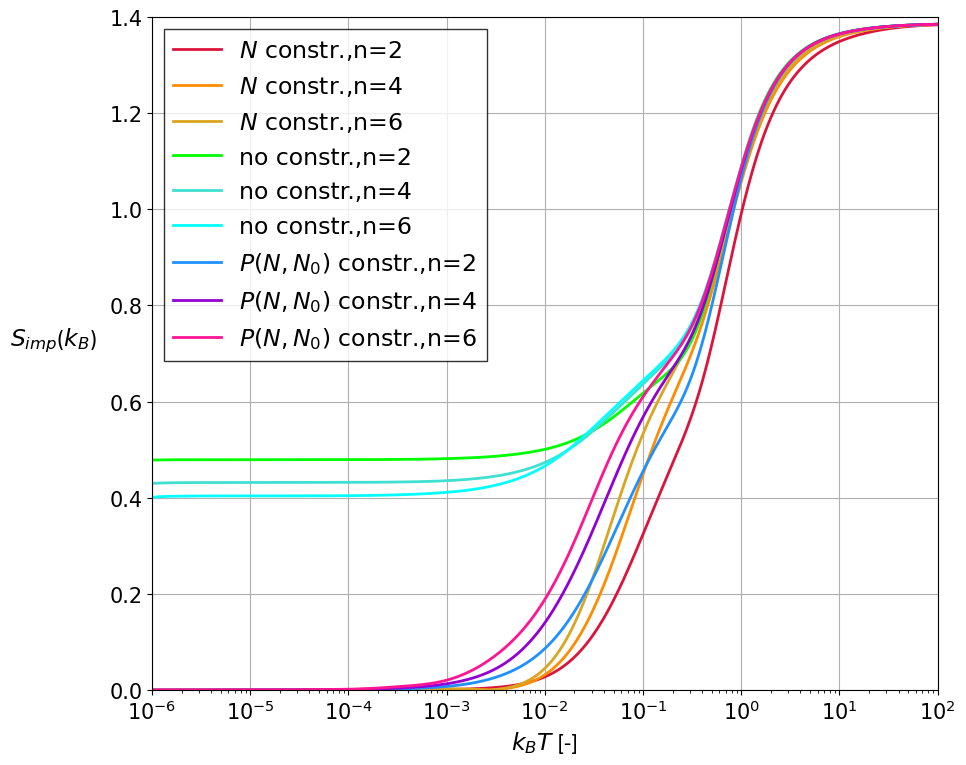

<module 'matplotlib.pyplot' from 'c:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\.conda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [171]:
DEDlib.Entropyplot(Tk,S_imp,np.char.add(np.repeat(labelnames,len(input)),np.tile([str(inp["poles"]) for inp in input],len(labelnames))),'STtotal')

In [163]:
S_imp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [157]:
DOST=np.zeros((6,16,1001))

In [150]:
DOST[0,0]=rho1
DOST[1,0]=rho1
DOST[1,1]=rho2
DOST[2,3]=rho3

DOST[3,3]=rho4
DOST[4,5]=rho5
DOST[5,0]=rho5
DOST[5,6]=rho6

In [151]:
fDOS=np.array([DOST[i,np.max(np.nonzero(nz))] for i,nz in enumerate(~np.any(DOST==0,2))])

In [152]:
fDOS

array([[0.01243791, 0.01251616, 0.01259545, ..., 0.01259185, 0.01250854,
        0.01242644],
       [0.01406047, 0.01415379, 0.01424843, ..., 0.01131607, 0.01124931,
        0.01118344],
       [0.01589893, 0.01601163, 0.01612583, ..., 0.0101404 , 0.01008738,
        0.01003522],
       [0.01882747, 0.01897306, 0.01912096, ..., 0.00888548, 0.00883753,
        0.00878966],
       [0.02971981, 0.02998258, 0.03024559, ..., 0.00673109, 0.00669907,
        0.00666728],
       [0.03080097, 0.03106291, 0.03132489, ..., 0.00553494, 0.00551268,
        0.00549079]])

In [139]:
DOST

array([[0.01243791+0.j, 0.01251616+0.j, 0.01259545+0.j, ...,
        0.01259185+0.j, 0.01250854+0.j, 0.01242644+0.j],
       [0.01406047+0.j, 0.01415379+0.j, 0.01424843+0.j, ...,
        0.01131607+0.j, 0.01124931+0.j, 0.01118344+0.j],
       [0.01589893+0.j, 0.01601163+0.j, 0.01612583+0.j, ...,
        0.0101404 +0.j, 0.01008738+0.j, 0.01003522+0.j],
       [0.01882747+0.j, 0.01897306+0.j, 0.01912096+0.j, ...,
        0.00888548+0.j, 0.00883753+0.j, 0.00878966+0.j],
       [0.02971981+0.j, 0.02998258+0.j, 0.03024559+0.j, ...,
        0.00673109+0.j, 0.00669907+0.j, 0.00666728+0.j],
       [0.03080097+0.j, 0.03106291+0.j, 0.03132489+0.j, ...,
        0.00553494+0.j, 0.00551268+0.j, 0.00549079+0.j]])

In [9]:
omega=DEDlib.textfileR("C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block6 ASAIM\\attempt4\\cN4p-1_5Ed1.5000000000000000Sigma.txt")[0]
rho1=DEDlib.textfileR("C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block6 ASAIM\\attempt4\\cN4p-1_5Ed1.5000000000000000Sigma.txt")[1]
rho2=DEDlib.textfileR("C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block6 ASAIM\\attempt4\\cN4p-1_65Ed1.6191895309433180Sigma.txt")[1]

rho3=DEDlib.textfileR("C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block6 ASAIM\\attempt4\\cN4p-1_8Ed1.7376710302545157Sigma.txt")[1]
rho4=DEDlib.textfileR("C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block6 ASAIM\\attempt4\\cN4p-2Ed1.8975235946859925Sigma.txt")[1]
rho5=DEDlib.textfileR("C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block6 ASAIM\\attempt6\\cN4p-2_5Ed2.2561819413918642Sigma.txt")[1]
rho6=DEDlib.textfileR("C:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\DEDdata\\Block6 ASAIM\\attempt5\\cN4p-3Ed2.6097224290640053Sigma.txt")[1]

In [145]:
DOST=np.array([rho1,rho2,rho3,rho4,rho5,rho6])

In [146]:
labelnames=['$\\rho,\\epsilon_d=%.1f$'%1.5,'$\\rho,\\epsilon_d=%.2f$'%1.65,'$\\rho,\\epsilon_d=%.1f$'%1.8,'$\\rho,\\epsilon_d=%.1f$'%2.0,'$\\rho,\\epsilon_d=%.1f$'%2.5,'$\\rho,\\epsilon_d=%.1f$'%3.0]

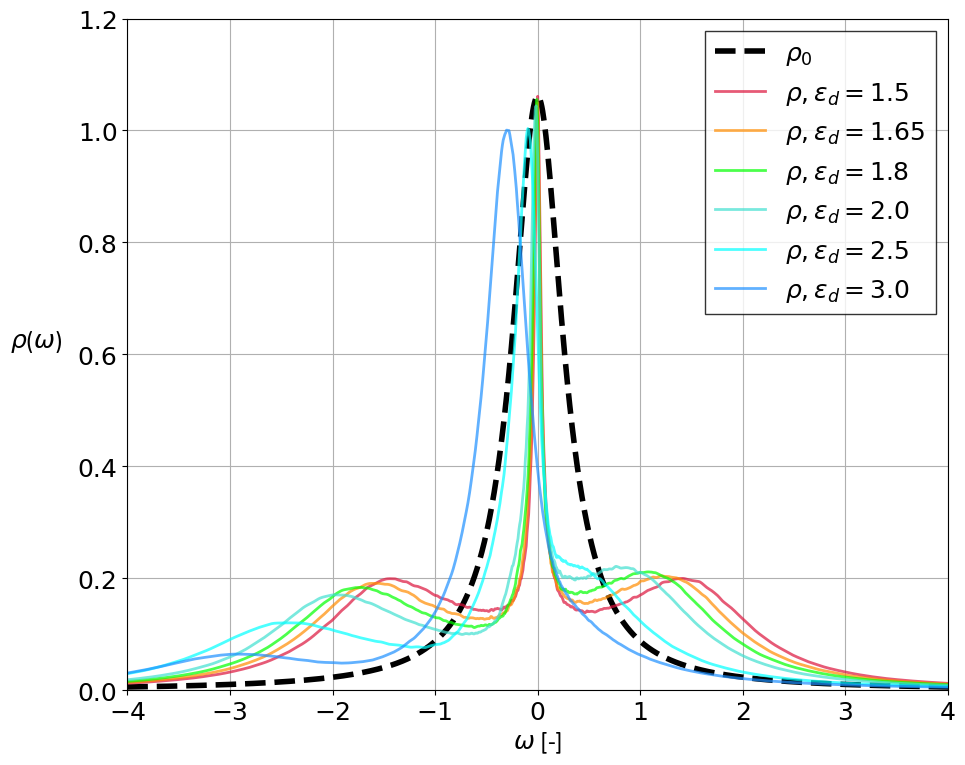

<module 'matplotlib.pyplot' from 'c:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\.conda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [153]:
DEDlib.DOSmultiplot(omega,np.tile(omega, (6,1)),fDOS,np.tile(len(omega), 6),labelnames,'Asymtotal',DEDlib.Lorentzian(omega,0.3,4,-3/2,3/2)[0])

In [10]:
rho1

array([0.01243791+0.j, 0.01251616+0.j, 0.01259545+0.j, ...,
       0.01259185+0.j, 0.01250854+0.j, 0.01242644+0.j])

In [2]:
input=[[[1,2,3],[2,5,6]]]

for l,inp in enumerate(input):
    print(l,inp)
    inp[0]=[0,0,0]
inp

0 [[1, 2, 3], [2, 5, 6]]


[[0, 0, 0], [2, 5, 6]]

In [1]:
np.linspace(-3,3,1001)[501]


NameError: name 'np' is not defined

In [38]:
"$\\rho$"

'$\\rho$'

In [57]:
sum(np.logspace(2.0, 5, num=50, base=10,dtype='int'))*20/10/60/60/24

17.588773148148146

In [36]:
DOST=np.zeros((16,1001),dtype = 'float')

In [17]:
s.shape

(50,)

In [18]:
b.shape

(50, 1001)

In [24]:
len(np.mean(np.zeros((50,1001)),axis=1))

50

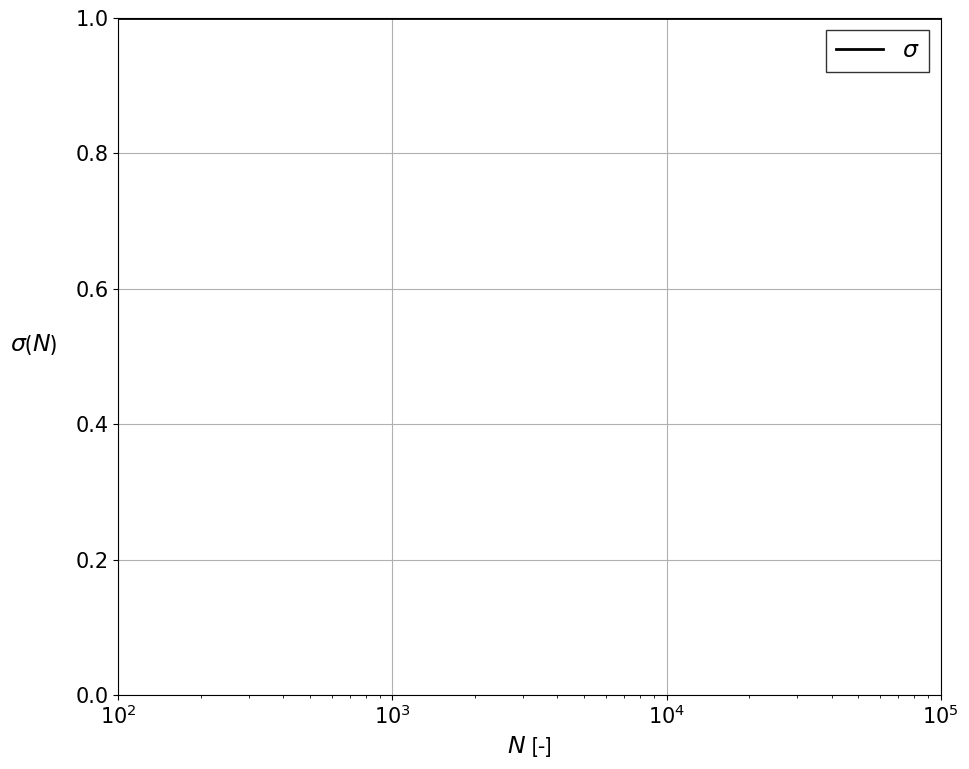

<module 'matplotlib.pyplot' from 'c:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\.conda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [2]:
import DEDlib
DEDlib.stdplot(np.logspace(2.0, 5, num=50, base=10,dtype='int'),np.ones((50,1001)),'g','$\\sigma$')

In [33]:
np.insert(b,0,s, axis=1)

array([[   100.,      0.,      0., ...,      0.,      0.,      0.],
       [   115.,      0.,      0., ...,      0.,      0.,      0.],
       [   132.,      0.,      0., ...,      0.,      0.,      0.],
       ...,
       [ 75431.,      0.,      0., ...,      0.,      0.,      0.],
       [ 86851.,      0.,      0., ...,      0.,      0.,      0.],
       [100000.,      0.,      0., ...,      0.,      0.,      0.]])

In [34]:

np.savetxt('test.txt',np.insert(b,0,s, axis=1),delimiter='\t', newline='\n')

In [26]:
s,b=np.logspace(2, 5, num=50, base=10,dtype='int'),np.zeros((50,1001))
tot=np.append(b,s, axis=0)
tot

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [ ]:
np.savetxt('test.txt',s,delimiter='\t', newline='\n')

In [48]:
d=np.zeros(5)

for x,d2 in enumerate(d):
    d2=1
    print(d2)
print(d)

1
1
1
1
1
[0. 0. 0. 0. 0.]


In [37]:
std=np.sqrt(np.sum([(dat-np.mean(DOST,axis=0))**2 for dat in DOST],axis=0)/(len(DOST)-1))
stdavg=std/np.sqrt(len(DOST))

In [17]:
data=np.array([[1,4,5,3,2,5,4,3,4,4,4,2,1,1,2,3,4],[3,4,5,3,2,5,4,3,3,4,4,2,5,1,2,4,4],[3,1,1,1,1,1,1,1,1,4,4,3,3,3,1,2,1]])
print(np.std(data,axis=0),np.var(data,axis=0),np.mean(data,axis=0))

[0.94280904 1.41421356 1.88561808 0.94280904 0.47140452 1.88561808
 1.41421356 0.94280904 1.24721913 0.         0.         0.47140452
 1.63299316 0.94280904 0.47140452 0.81649658 1.41421356] [0.88888889 2.         3.55555556 0.88888889 0.22222222 3.55555556
 2.         0.88888889 1.55555556 0.         0.         0.22222222
 2.66666667 0.88888889 0.22222222 0.66666667 2.        ] [2.33333333 3.         3.66666667 2.33333333 1.66666667 3.66666667
 3.         2.33333333 2.66666667 4.         4.         2.33333333
 3.         1.66666667 1.66666667 3.         3.        ]


In [22]:
np.sqrt(np.sum([(dat-np.mean(data,axis=0))**2 for dat in data],axis=0)/(len(data)-1))/np.sqrt(len(data))

array([0.66666667, 1.        , 1.33333333, 0.66666667, 0.33333333,
       1.33333333, 1.        , 0.66666667, 0.8819171 , 0.        ,
       0.        , 0.33333333, 1.15470054, 0.66666667, 0.33333333,
       0.57735027, 1.        ])

In [24]:
x=(1,2)

y=np.zeros((2,2))

y[0]=x

In [25]:
y

array([[1., 2.],
       [0., 0.]])

In [ ]:
N=10000
poles=4
U=3
Sigma=3/2
Ed=-3/2
Gamma=0.3
SizeO=1001
etaco=[0.02,1e-39]
ctype='n'
bound=3
Tk=[0]
posb=1

omega,eta,selectpcT,selectpT= np.linspace(-bound,bound,SizeO),etaco[0]*abs(np.linspace(-bound,bound,SizeO))+etaco[1],[],[]

kb=1
NewM,nonG,select=Startrans(poles,np.sort(Lorentzian(omega, Gamma, poles,Ed,Sigma)[1]),omega,eta)
E_k=[NewM[k+1][k+1] for k in range(len(NewM)-1)]
H0,H=HamiltonianAIM(c,NewM[0][0],E_k,NewM[0,1:],U,Sigma)
evals,evecs=scipy.linalg.eigh(H.data.toarray())
Z_tot=np.sum(np.exp(-evals/Tk))
Hexp=np.sum(evals*np.exp(-evals/Tk))/Z_tot
Z_bath=2*np.prod([1+np.exp(ek/Tk) for ek in E_k])
Hbexp=2*np.sum([ek/(1+np.exp(ek/Tk)) for ek in E_k])
S_bath=kb(np.log(np.sum(Z_bath))+Hbexp/Tk)
S_tot=kb(np.log(np.sum(Z_tot))+Hexp/Tk)
S_imp=S_tot-S_bath

In [2]:
def ConstraintS(ctype,H0,H,n,Tk,Nfin=0):
    if ctype[0]=='s':
        vecs=scipy.linalg.eigh(H0.data.toarray(),eigvals=[0, 0])[1][:,0]
        evals,evecs=scipy.linalg.eigh(H.data.toarray())
        if ctype=='ssn':
            Boltzmann=np.exp(-abs(evals[find_nearest(np.diag(np.conj(evecs).T@n.data@evecs),np.conj(vecs)@n.data@vecs.T)]-evals[0])/Tk)*Nfin.astype('int')
            return Boltzmann,evals
        else: return np.exp(-abs(evals[find_nearest(np.diag(np.conj(evecs).T@n.data@evecs),np.conj(vecs)@n.data@vecs.T)]-evals[0])/Tk),evals
    elif ctype[0]=='n':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.sparse.linalg.eigsh(np.real(H0.data), k=1, which='SA')[1][:,0],
                                                scipy.sparse.linalg.eigsh(np.real(H.data), k=1, which='SA')[1][:,0])))
        exp=np.conj(vecs)@n.data@vecs.T
        if ctype=='n%2' and int(np.round(exp[0,0]))%2==int(np.round(exp[1,1]))%2: return np.ones(len(Tk)),[]
        elif ctype=='n' and np.round(exp[0,0])==np.round(exp[1,1]): return np.ones(len(Tk)),[]
        else: return np.zeros(len(Tk)),[]
    elif ctype[0]=='d':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.linalg.eigh(H.data.toarray(),eigvals=[0, 0])[1][:,0],
                                                scipy.linalg.eigh(H0.data.toarray(),eigvals=[0, 0])[1][:,0])))
        exp=np.conj(vecs)@n.data@vecs.T
        if ctype=='dn' and np.round(exp[0,0])==np.round(exp[1,1]): return np.ones(len(Tk)),[]
        else: return np.zeros(len(Tk)),[]
    else: return np.ones(len(Tk)),[]   

In [3]:
def find_nearest(array,value):
    for i in (i for i,arrval in enumerate(array) if np.isclose(arrval, value, atol=0.1)): return i

In [4]:
def Jordan_wigner_transform(j, lattice_length):
    """Jordan_wigner_transform(j, lattice_length). 
Defines the Jordan Wigner transformation for a 1D lattice."""
    operators = sigmaz()
    for _ in range(j-1): operators = tensor(operators, sigmaz())
    if j == 0: operators = sigmam()
    else: operators = tensor(operators, sigmam())
    for _ in range(lattice_length - j - 1): operators = tensor(operators, identity(2))
    return operators

In [5]:
@njit
def Startrans(poles,select,omega, eta,row=0):
    """Startrans(poles,select,row,omega, eta). 
Function to transform 1D lattice matrices in order to calculates parameters impengergy, bathenergy and Vkk from random sampling distribution."""
    Pbath,Dbath,pbar,G=np.zeros((poles, poles)),np.zeros((poles,poles)),np.zeros((poles, poles)),np.zeros(omega.shape,dtype = 'complex_')
    for i in range(poles-1):
        for j in range(poles-1):
            if j>=i: Pbath[i+1][j+1]=-1/sqrt((poles-i-1)*(poles-i))
        Pbath[i+1][i]=sqrt(poles-i-1)/sqrt(poles-i)
    Pbath[row,:]=1/sqrt(poles)
    for i, _ in enumerate(select): Dbath[i][i]=select[i]
    pbar[1:,1:]=np.linalg.eig((Pbath@Dbath@Pbath.T)[1:,1:])[1]
    pbar[row][row]=1
    for i, _ in enumerate(select): G+=1 / len(select) / (omega - select[i] + 1.j * eta)
    return pbar.T@Pbath@Dbath@Pbath.T@pbar,G,select

In [6]:
@njit
def Lorentzian(omega, Gamma, poles,Ed=-3/2,Sigma=3/2):
    """Lorentzian(omega, Gamma, poles,Ed=-3/2,Sigma=3/2). 
Defines the non-interacting DOS (rho0) and selects random sites based on the number of sites in the 1D lattice model and the calculated distribution."""
    p = np.random.uniform(0, 1, poles)
    return -np.imag(1/(omega-Ed-Sigma+1j*Gamma))/np.pi, np.array([Gamma * np.tan(np.pi * (p[i] - 1 / 2))+Ed+Sigma for i in range(poles)])

In [7]:
def HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma, H0 = 0):
    """HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma). 
Based on energy parameters calculates the Hamiltonian of a single-impurity system."""
    for i in range(2):
        H0 += impenergy * (c[i].dag() * c[i])
        for j, bathE in enumerate(bathenergy):
            H0 += Vkk[j] * (c[i].dag() * c[2 * j + i + 2] + c[2 * j + i + 2].dag() * c[i])+ bathE * (c[2 * j + i + 2].dag() * c[2 * j + i + 2])
    return H0,H0+U * (c[0].dag() * c[0] * c[1].dag() * c[1])-Sigma * (c[0].dag() * c[0] + c[1].dag() * c[1])

In [297]:
N=10000
poles=4
U=3
Sigma=3/2
Ed=-3/2
Gamma=0.3
SizeO=1001
etaco=[0.02,1e-39]
ctype='n'
bound=3
Tk=np.array([0.000001,0.00001,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,10,100])
posb=1
omega,eta,selectpcT,selectpT,S_imp,kb,c= np.linspace(-bound,bound,SizeO),etaco[0]*abs(np.linspace(-bound,bound,SizeO))+etaco[1],[],[],np.zeros(len(Tk),dtype = 'float'),1,[Jordan_wigner_transform(i, 2*poles) for i in range(2*poles)]
pbar=trange(N,position=posb,leave=False,desc='Iterations',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
n,Nfin,i=sum([c[i].dag()*c[i] for i in range(2*poles)]),np.zeros(len(Tk),dtype = 'float'),0

constr=np.zeros(len(Tk),dtype = 'float')
while np.array([con==0 for con in constr]).all():
    NewM,_,select=Startrans(poles,np.sort(Lorentzian(omega, Gamma, poles,Ed,Sigma)[1]),omega,eta)
    E_k=[NewM[k+1][k+1] for k in range(len(NewM)-1)]
    H0,H=HamiltonianAIM(c,NewM[0][0],E_k,NewM[0,1:],U,Sigma)
    constr=ConstraintE(ctype,H0,H,n,Tk)
    selectpT.append(select)
selectpcT.append(select)
evals,_=scipy.linalg.eigh(H.data.toarray())

Iterations:   0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
import time
def Entropyimp2(N=10000,poles=4,U=3,Sigma=3/2,Ed=-3/2,Gamma=0.3,SizeO=1001,etaco=[0.02,1e-39],ctype='n',bound=3,Tk=[0],posb=0):
    omega,eta,selectpcT,selectpT,S_imp,S_t,S_b,kb,c= np.linspace(-bound,bound,SizeO),etaco[0]*abs(np.linspace(-bound,bound,SizeO))+etaco[1],[],[],np.zeros(len(Tk),dtype=np.float64),np.zeros(len(Tk),dtype=np.float64),np.zeros(len(Tk),dtype=np.float64),1,[Jordan_wigner_transform(i, 2*poles) for i in range(2*poles)]
    pbar=trange(N,position=posb,leave=False,desc='Iterations',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    n,Nfin,i=sum([c[i].dag()*c[i] for i in range(2*poles)]),np.zeros(len(Tk),dtype = 'float'),0
    while (np.array([ar<N for _,ar in enumerate(Nfin)]).any() and ctype!='sn') or i<N:
        constr=np.zeros(len(Tk),dtype = 'float')
        while np.array([con==0 for con in constr]).all():
            NewM,_,select=Startrans(poles,np.sort(Lorentzian(omega, Gamma, poles,Ed,Sigma)[1]),omega,eta)
            E_k=[NewM[k+1][k+1] for k in range(len(NewM)-1)]
            H0,H=HamiltonianAIM(c,NewM[0][0],E_k,NewM[0,1:],U,Sigma)
            constr,evals=ConstraintS(ctype,H0,H,n,Tk)
            selectpT.append(select)
        selectpcT.append(select)
        #if ctype==' ':
        #    evals=H.eigenenergies()
        #else:
        if ~np.any(evals):
            evals,_=scipy.linalg.eigh(H.data.toarray())
        Z_tot=scipy.special.logsumexp(np.multiply.outer(-evals,1/Tk,dtype=np.float64),axis=0)


        if (Z_tot>2e+08).any():
            continue
        #Hexp=np.sum(evals[:,None]*np.exp(np.outer(-evals,1/Tk)-Z_tot),axis=0)
        #print(evals[0])
        #Z_tot=-evals[0]/Tk
        #for eval in evals[1:]:
        #    Z_tot=np.logaddexp(Z_tot,-eval/Tk)
        Hexp=np.sum(evals[:,None]*np.exp(np.multiply.outer(-evals,1/Tk,dtype=np.float64)-Z_tot),axis=0)
        
        S_tot=kb*(Z_tot+Hexp/Tk)
        Z_bath=2*sum([np.logaddexp(np.zeros(len(Tk)),-ek/Tk) for ek in E_k])
        H_bath=2*np.sum([ek/np.exp(np.logaddexp(np.zeros(len(Tk)),ek/Tk)) for ek in E_k],axis=0)

        S_bath=kb*(Z_bath+H_bath/Tk)
        S_t+=S_tot*constr
        S_b+=S_bath*constr
        S_imp+=(S_tot-S_bath)*constr
        i+=1
        Nfin+=constr
        #if i>100:
        #    if (0.4>S_t[0:5]/Nfin[0:5]).any() or (0.5<S_t[0:5]/Nfin[0:5]).any():
        #        print(S_t[0:5]/Nfin[0:5],Z_tot[0:5],Hexp[0:5], end='\r')
        #        time.sleep(0.5)
        if ctype=='sn': pbar.n=i
        else: pbar.n=int(min(Nfin))
        pbar.refresh()
    pbar.close()
    return np.abs(S_imp/Nfin).squeeze(),np.real(S_t/Nfin).squeeze(),np.real(S_b/Nfin).squeeze(),Nfin.squeeze(),i

In [17]:
def ConstraintS(ctype,H0,H,n,Tk,Nfin=0):
    if ctype[0]=='s':
        vecs=scipy.linalg.eigh(H0.data.toarray(),eigvals=[0, 0])[1][:,0]
        evals,evecs=scipy.linalg.eigh(H.data.toarray())
        if ctype=='ssn':
            Boltzmann=np.exp(-abs(evals[find_nearest(np.diag(np.conj(evecs).T@n.data@evecs),np.conj(vecs)@n.data@vecs.T)]-evals[0])/Tk)*Nfin.astype('int')
            return Boltzmann,evals
        else: return np.exp(-abs(evals[find_nearest(np.diag(np.conj(evecs).T@n.data@evecs),np.conj(vecs)@n.data@vecs.T)]-evals[0])/Tk),evals
    elif ctype[0]=='n':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.sparse.linalg.eigsh(np.real(H0.data), k=1, which='SA')[1][:,0],
                                                scipy.sparse.linalg.eigsh(np.real(H.data), k=1, which='SA')[1][:,0])))
        exp=np.conj(vecs)@n.data@vecs.T
        if ctype=='n%2' and int(np.round(exp[0,0]))%2==int(np.round(exp[1,1]))%2: return np.ones(len(Tk)),[]
        elif ctype=='n' and np.round(exp[0,0])==np.round(exp[1,1]): return np.ones(len(Tk)),[]
        else: return np.zeros(len(Tk)),[]
    elif ctype[0]=='d':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.linalg.eigh(H.data.toarray(),eigvals=[0, 0])[1][:,0],
                                                scipy.linalg.eigh(H0.data.toarray(),eigvals=[0, 0])[1][:,0])))
        exp=np.conj(vecs)@n.data@vecs.T
        if ctype=='dn' and np.round(exp[0,0])==np.round(exp[1,1]): return np.ones(len(Tk)),[]
        else: return np.zeros(len(Tk)),[]
    else: return np.ones(len(Tk)),[]

#def SAIM(evals,Z_tot,Tk,kb,E_k,constr,S_t,S_b,S_imp,Nfin):
#    S_tot=kb*(Z_tot+np.sum(evals[:,None]*np.exp(np.multiply.outer(-evals,1/Tk,dtype=np.float64)-Z_tot),axis=0)/Tk)
#    S_bath=kb*(2*sum([np.logaddexp(np.zeros(len(Tk)),-ek/Tk) for ek in E_k])+2*np.sum([ek/np.exp(np.logaddexp(np.zeros(len(Tk)),ek/Tk)) for ek in E_k],axis=0)/Tk)
#    return S_t+S_tot*constr,S_b+S_bath*constr,S_imp+(S_tot-S_bath)*constr,Nfin+constr

@njit
def SAIM(evals,Z_tot,Tk,kb,E_k,constr,S_t,S_b,S_imp,Nfin):
    S_tot,S_bath=kb*(Z_tot+evals@np.exp(np.outer(-evals,1/Tk)-Z_tot)/Tk),np.zeros(len(Tk))
    for ek in E_k: S_bath+=2*kb*(np.logaddexp(np.zeros(len(Tk)),-ek/Tk)+ek/np.exp(np.logaddexp(np.zeros(len(Tk)),ek/Tk))/Tk)
    return S_t+S_tot*constr,S_b+S_bath*constr,S_imp+(S_tot-S_bath)*constr,Nfin+constr

def Entropyimp(N=10000,poles=4,U=3,Sigma=3/2,Ed=-3/2,Gamma=0.3,SizeO=1001,etaco=[0.02,1e-39],ctype='n',bound=3,Tk=[0],kb=1,posb=0):
    omega,eta,selectpcT,selectpT,S_imp,S_t,S_b,c= np.linspace(-bound,bound,SizeO),etaco[0]*abs(np.linspace(-bound,bound,SizeO))+etaco[1],[],[],np.zeros(len(Tk),dtype=np.float64),np.zeros(len(Tk),dtype=np.float64),np.zeros(len(Tk),dtype=np.float64),[Jordan_wigner_transform(i, 2*poles) for i in range(2*poles)]
    n,Nfin,pbar=sum([c[i].dag()*c[i] for i in range(2*poles)]),np.zeros(len(Tk),dtype = 'float'),trange(N,position=posb,leave=False,desc='Iterations',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    while pbar.n<N:
        t1=time()
        constr=np.zeros(len(Tk),dtype = 'float')
        while np.array([con==0 for con in constr]).all():
            NewM,_,select=Startrans(poles,np.sort(Lorentzian(omega, Gamma, poles,Ed,Sigma)[1]),omega,eta)
            E_k=np.array([NewM[k+1][k+1] for k in range(len(NewM)-1)])
            print(time()-t1)
            H0,H=HamiltonianAIM(c,NewM[0][0],E_k,NewM[0,1:],U,Sigma)
            constr,evals=ConstraintS(ctype,H0,H,n,Tk)
            selectpT.append(select)
        print(time()-t1)
        selectpcT.append(select)
        if ~np.any(evals): evals=scipy.linalg.eigvalsh(H.data.toarray())
        Z_tot=scipy.special.logsumexp(np.outer(-evals,1/Tk),axis=0)
        if (Z_tot>2e+08).any(): continue
        else: S_t,S_b,S_imp,Nfin=SAIM(evals,Z_tot,Tk,kb,E_k,constr,S_t,S_b,S_imp,Nfin)
        if ctype=='sn': pbar.n+=1
        else: pbar.n=int(min(Nfin))
        pbar.refresh()
    pbar.close()
    return np.abs(S_imp/Nfin).squeeze(),np.real(S_t/Nfin).squeeze(),np.real(S_b/Nfin).squeeze(),Nfin.squeeze(),Tk,(pbar.format_dict["n"],pbar.format_dict["elapsed"])

In [18]:
Ni=1#200000 poles=4
S4=Entropyimp(N=1,poles=6,Tk=np.logspace(-6,2,801,base=10),ctype='sn')

Iterations:   0%|          | 0/1 [00:00<?, ?it/s]

0.001001119613647461


C:\Users\roelv\AppData\Local\Temp\ipykernel_33384\2819419618.py:3: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  vecs=scipy.linalg.eigh(H0.data.toarray(),eigvals=[0, 0])[1][:,0]


KeyboardInterrupt: 

In [378]:
Ni=20000#200000 poles=4
S4v3=Entropyimp(N=200000,poles=4,Tk=np.logspace(-6,2,801,base=10))

Iterations:   0%|          | 0/200000 [00:00<?, ?it/s]

In [380]:
S4v3[4]

(200000, 14654.786114692688)

In [365]:
S4v2=Entropyimp2(N=Ni,poles=4,Tk=np.logspace(-6,2,801,base=10))

Iterations:   0%|          | 0/20000 [00:00<?, ?it/s]

In [221]:
colors=['crimson','darkorange','goldenrod','lime','turquoise','cyan','dodgerblue','darkviolet','deeppink']

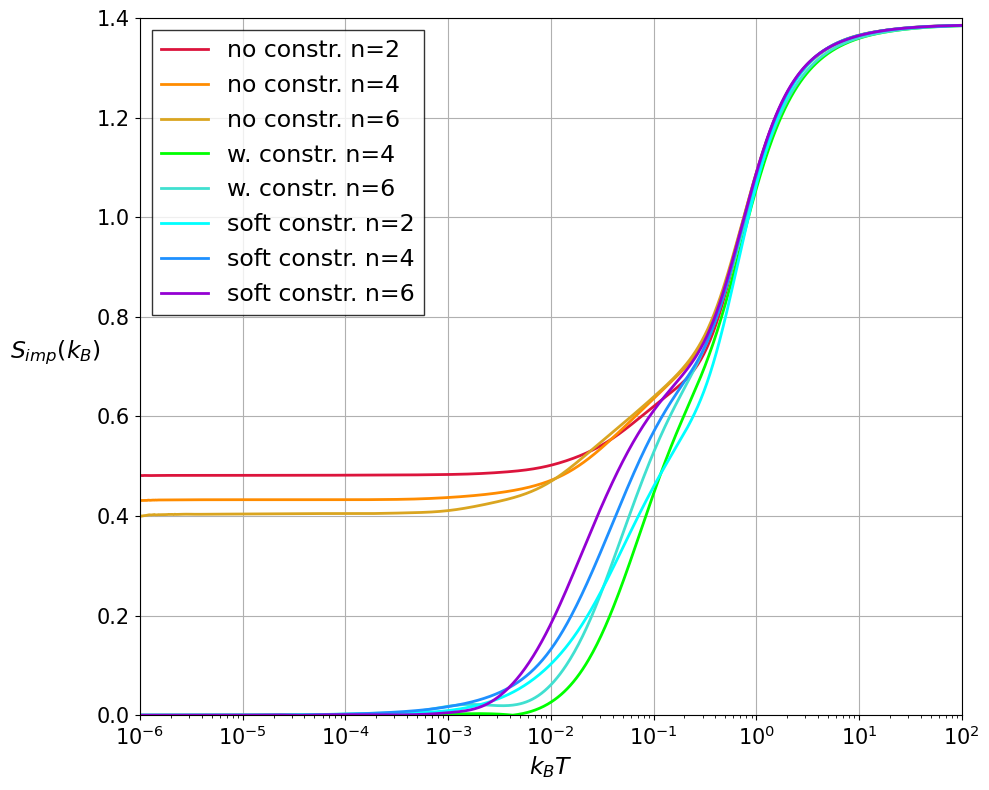

In [225]:
Tk=np.logspace(-6,2,801,base=10)

plt.figure(figsize=(10,8))
plt.rc('legend', fontsize=17)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
axis_font = {'fontname':'Calibri', 'size':'17'}
plt.xlim(min(Tk), max(Tk))
plt.xscale('log')
plt.xlabel("$k_BT$", **axis_font)
plt.gca().set_ylabel("$S_{imp}(k_B)$",va="bottom", rotation=0,labelpad=30,**axis_font)
plt.gca().set_ylim(bottom=0,top=1.4)
plt.plot(Tk,Sno2[0],'-', color=colors[0],linewidth=2,label='no constr. n=2')
plt.plot(Tk,Sno[0],'-', color=colors[1],linewidth=2,label='no constr. n=4')
plt.plot(Tk,Sno6[0],'-', color=colors[2],linewidth=2,label='no constr. n=6')
plt.plot(Tk,S4[0],'-', color=colors[3],linewidth=2,label='w. constr. n=4')
plt.plot(Tk,S[0],'-', color=colors[4],linewidth=2,label='w. constr. n=6')
plt.plot(Tk,Ssn2[0],'-', color=colors[5],linewidth=2,label='soft constr. n=2')
plt.plot(Tk,Ssn[0],'-', color=colors[6],linewidth=2,label='soft constr. n=4')
plt.plot(Tk,Ssn6[0],'-', color=colors[7],linewidth=2,label='soft constr. n=6')
plt.legend(fancybox=False).get_frame().set_edgecolor('black')
plt.grid()
plt.tight_layout()

In [ ]:
#test new function constraint

In [ ]:
"""sn takes longer because of constraint linalg.eigh"""

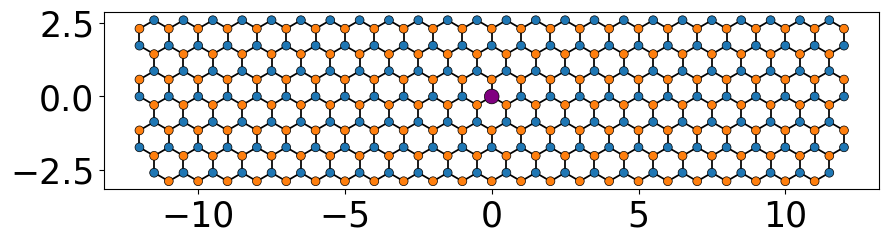

In [2]:
imp,func,args,colorbnd,structname,nd=85,DEDlib.GrapheneNRarmchairstruct,(3,12,-2.8867513459481287),171,'armchair',np.zeros((2,4,2),dtype = 'float')


psi,SPG,eig,SPrho0=DEDlib.GrapheneAnalyzer(imp,func(*args),colorbnd,'GrapheneNR'+structname+str(imp)+'pos')        

In [9]:
nd[1]

array([1.00152831, 1.00165914, 1.00170411, 1.00315413, 1.00228651,
       1.00382232])

Iterations:   0%|          | 0/2000 [00:00<?, ?it/s]

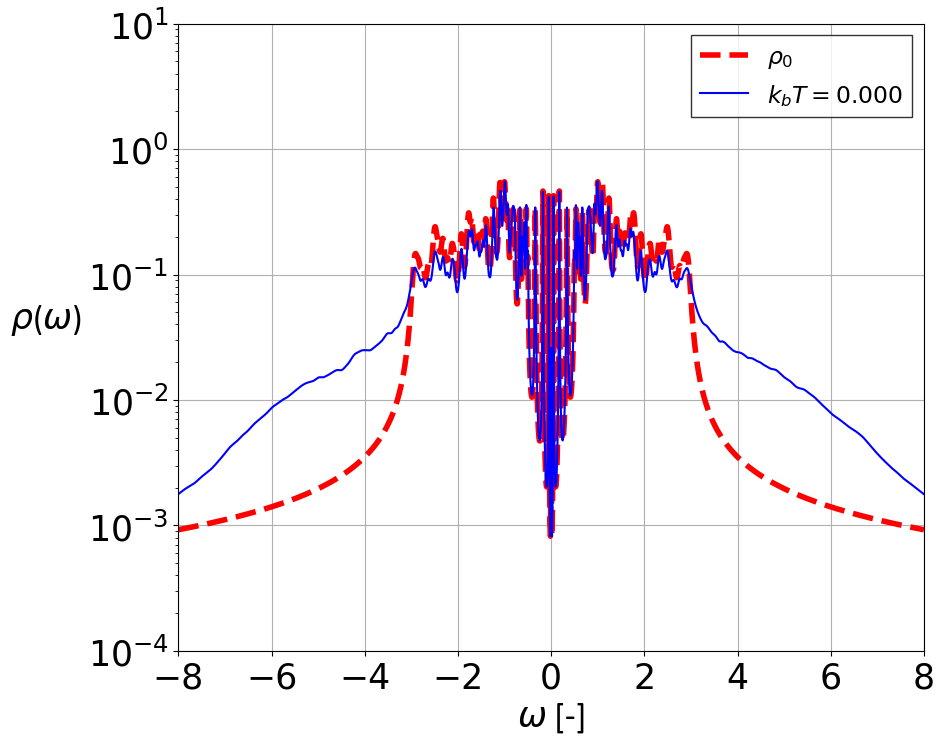

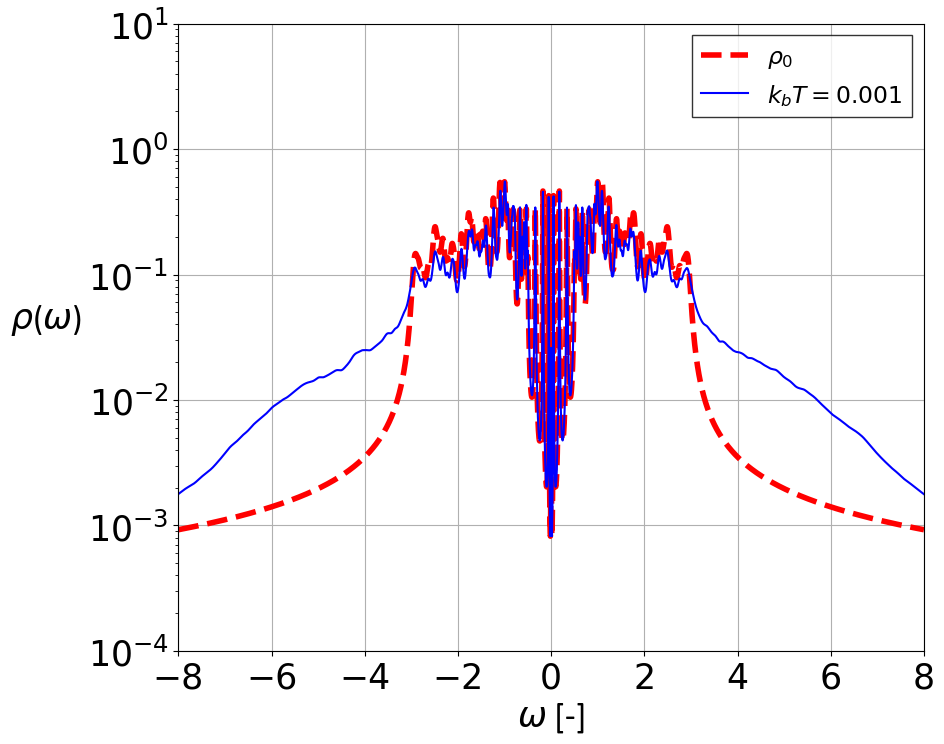

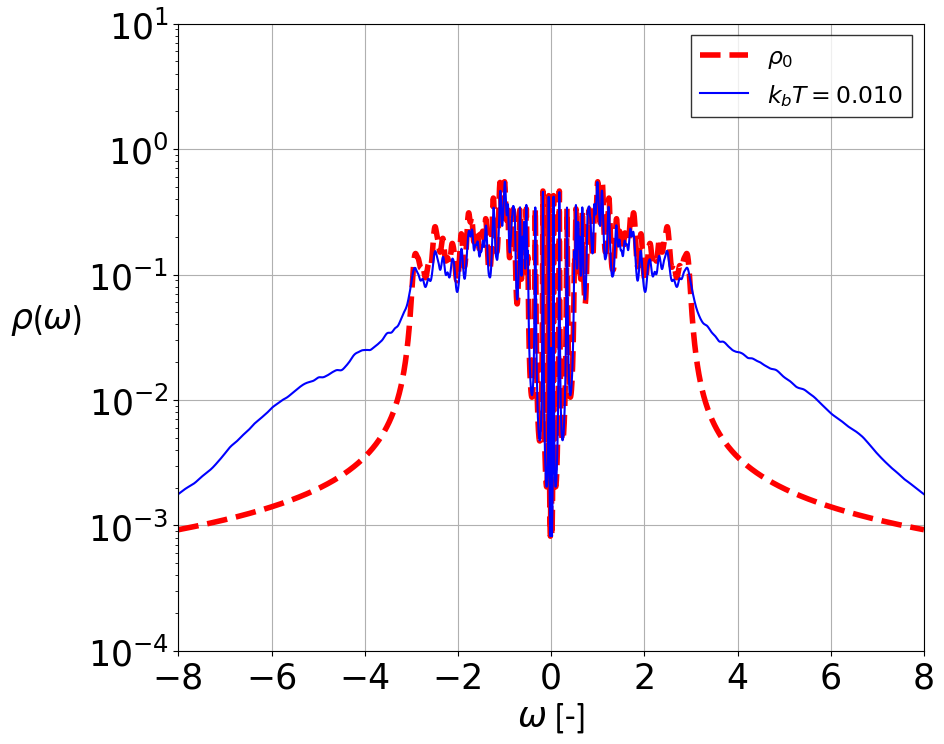

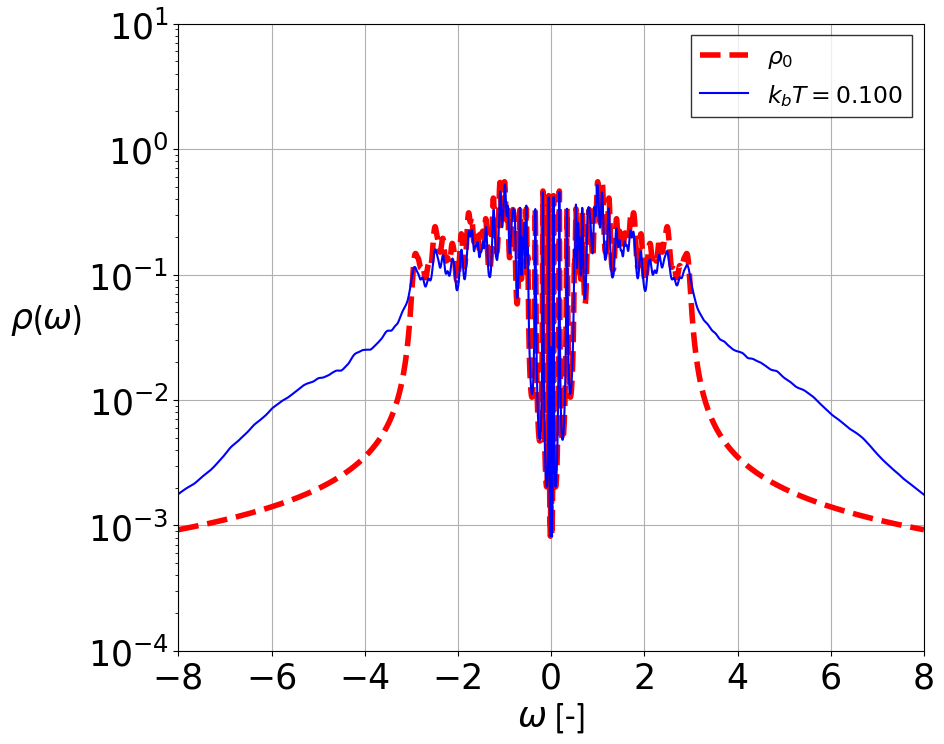

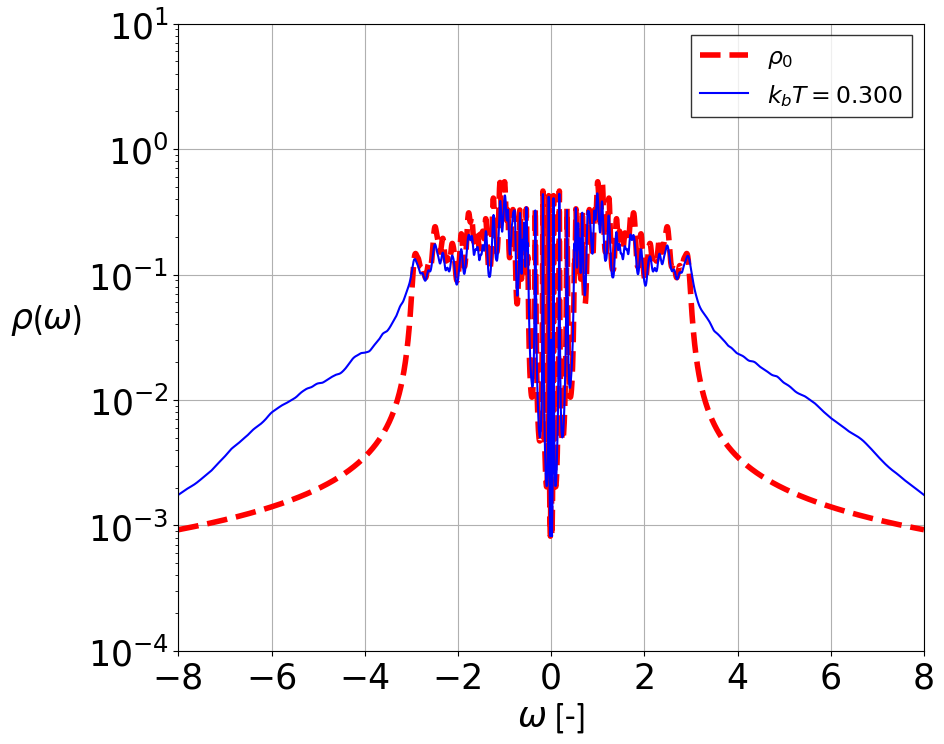

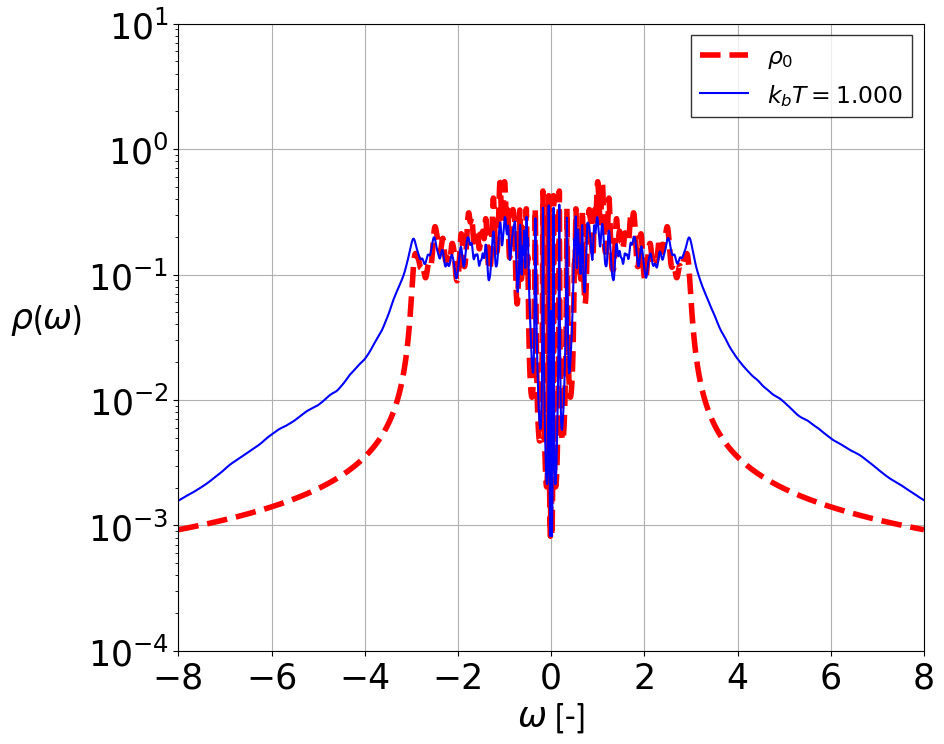

In [3]:
inp={"N" : 2000, "poles" : 4, "U" : 3, "Sigma" : 1.5, "Ed" : -3/2, "ctype" : 'ssn', "bound" : 8, "eigsel" : False,"Tk" : [0.000000000001,0.001,0.01,0.1,0.3,1]}
labelnames=['$\it{k_bT= %.3f}$'%0.000,'$\it{k_bT= %.3f}$'%0.001,'$\it{k_bT= %.3f}$'%0.010,'$\it{k_bT= %.3f}$'%0.100,'$\it{k_bT= %.3f}$'%0.300,'$\it{k_bT= %.3f}$'%1.000]
filenames=['cN4pT1e-12','cN4pT1e-3','cN4pT1e-2','cN4pT1e-1','cN4pT3e-1','cN4pT1']
nd, AvgSigmadat, DOST, nonintrho, omega, selectpT, selectpcT=DEDlib.Graphene_main(psi,SPG,eig,SPrho0,**inp,posb=4)
for i,file in enumerate(filenames):
    DEDlib.DOSplot(DOST[i], nonintrho, omega,file,labelnames[i],log=True)